In [1]:
import os
import csv


In [2]:
wearing_gear_dir = r"C:\Users\yaazh\OneDrive\Desktop\safety gear dataset\GearedorNot\Wearing Safety Gear"
not_wearing_gear_dir = r"C:\Users\yaazh\OneDrive\Desktop\safety gear dataset\GearedorNot\Not Wearing Safety Gear"

In [3]:
csv_file = r"C:\Users\yaazh\OneDrive\Desktop\safety gear labels.csv"

In [4]:
data = []

for filename in os.listdir(wearing_gear_dir):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(wearing_gear_dir, filename)  # Get full path
        data.append([filename, img_path, 1])  # Append filename, path, and label 1

# Append filename, full path, and label for images in the "not wearing gear" directory
for filename in os.listdir(not_wearing_gear_dir):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(not_wearing_gear_dir, filename)  # Get full path
        data.append([filename, img_path, 0]) 


In [5]:

with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['filename', 'path', 'label'])  # Write header
    writer.writerows(data) 

In [6]:
import cv2
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

In [7]:
df = pd.read_csv(csv_file)
image_paths = df['path'].values
labels = df['label'].values


In [8]:
image_size = (128, 128)

# Load and preprocess images
def load_and_preprocess_images(image_paths, image_size):
    images = []
    for img_path in image_paths:
        img = cv2.imread(img_path)
        img = cv2.resize(img, image_size)  # Resize image
        img = img / 255.0  # Normalize pixel values
        images.append(img)
    return np.array(images)

In [9]:
images = load_and_preprocess_images(image_paths, image_size)
labels = np.array(labels)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

In [11]:
def build_cnn_model(input_shape):
    model = Sequential()
    
    # First convolutional layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Second convolutional layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Third convolutional layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten the output for fully connected layers
    model.add(Flatten())
    
    # Fully connected layer
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))  # Dropout to reduce overfitting
    
    # Output layer (binary classification)
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [12]:
model = build_cnn_model(input_shape=(128, 128, 3))

C:\Users\yaazh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

In [14]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[checkpoint])

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 747ms/step - accuracy: 0.5472 - loss: 0.9644 - val_accuracy: 0.5775 - val_loss: 0.6624
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 677ms/step - accuracy: 0.5293 - loss: 0.6899 - val_accuracy: 0.8169 - val_loss: 0.6456
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 443ms/step - accuracy: 0.7221 - loss: 0.6218 - val_accuracy: 0.8169 - val_loss: 0.5055
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 551ms/step - accuracy: 0.7847 - loss: 0.5011 - val_accuracy: 0.7324 - val_loss: 0.5260
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 679ms/step - accuracy: 0.8461 - loss: 0.3957 - val_accuracy: 0.8310 - val_loss: 0.3513
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 540ms/step - accuracy: 0.8686 - loss: 0.3271 - val_accuracy: 0.8169 - val_loss: 0.3325
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 504ms/step - accuracy: 0.9270 - loss: 0.2258 - val_accuracy: 0.8169 - val_loss: 0.2990
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 640ms/step - accuracy: 0.9071 - loss: 0.1926 - val_accuracy: 0.9014 - val_loss

In [15]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9891 - loss: 0.1407 
Validation Accuracy: 98.59%


In [16]:
model.save('safety_gear_classifier_model.keras')

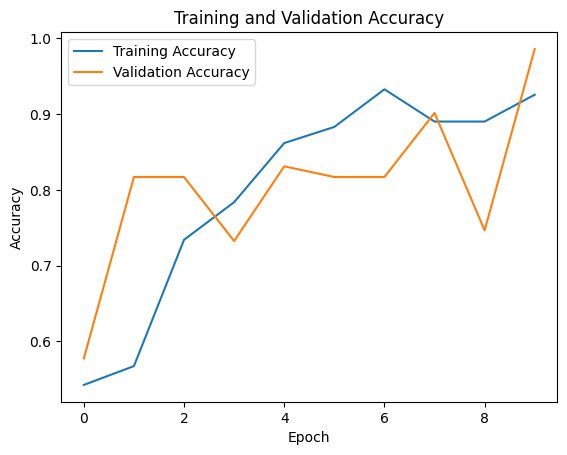

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


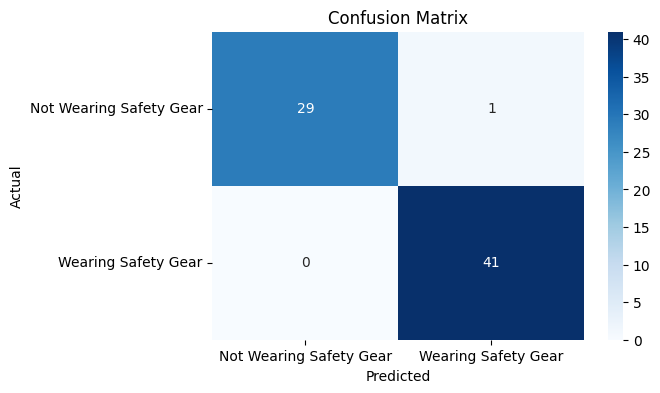

In [31]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_val, X_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Wearing Safety Gear', 'Wearing Safety Gear'], yticklabels=['Not Wearing Safety Gear', 'Wearing Safety Gear'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [18]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image

In [19]:
def predict_safety_gear(model, img_path, img_size=(128, 128)):
    # Load the image from the given path
    img = cv2.imread(img_path)
    # Resize the image to the model's expected input size
    img_resized = cv2.resize(img, img_size)

    # Normalize pixel values to [0, 1]
    img_normalized = img_resized / 255.0

    # Add a batch dimension (as the model expects a batch of images)
    img_batch = np.expand_dims(img_normalized, axis=0)

    # Make the prediction
    prediction = model.predict(img_batch)

    # Assuming the model outputs a probability (e.g., 0 or 1)
    if prediction > 0.5:
        return "Wearing Safety Gear"
    else:
        return "Not Wearing Safety Gear"

    


In [20]:
img_path = r"C:\Users\yaazh\OneDrive\Desktop\istockphoto-1311655328-612x612.jpg"
prediction = predict_safety_gear(model, img_path)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Not Wearing Safety Gear


In [21]:
img_path = r"C:\Users\yaazh\OneDrive\Desktop\images (3).jpeg"
prediction = predict_safety_gear(model, img_path)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Wearing Safety Gear


In [22]:
from sklearn.metrics import classification_report

In [23]:
x_pred = model.predict(X_val)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


In [25]:
print(x_pred)

[[1.39638811e-01]
 [7.33091116e-01]
 [3.00839934e-02]
 [1.83333173e-01]
 [9.92567480e-01]
 [1.63111836e-01]
 [9.72238302e-01]
 [9.68945920e-01]
 [8.78317714e-01]
 [7.51366556e-01]
 [9.75866556e-01]
 [7.35755205e-01]
 [9.99127328e-01]
 [7.76130240e-04]
 [9.10986125e-01]
 [9.87277746e-01]
 [9.99991238e-01]
 [4.15644169e-01]
 [9.90954041e-01]
 [8.07169080e-03]
 [9.99994814e-01]
 [9.34520811e-02]
 [1.80085912e-01]
 [9.99972820e-01]
 [7.22361326e-01]
 [9.85353291e-01]
 [9.99940872e-01]
 [5.74143417e-02]
 [9.99881208e-01]
 [8.78317714e-01]
 [9.75952327e-01]
 [9.78277087e-01]
 [2.16441318e-01]
 [9.99127328e-01]
 [9.94647622e-01]
 [5.45982361e-01]
 [9.16907430e-01]
 [3.37802097e-02]
 [9.84789252e-01]
 [7.35755205e-01]
 [5.22036664e-03]
 [7.40901113e-01]
 [7.04231788e-04]
 [9.53545034e-01]
 [9.95235682e-01]
 [2.44503692e-01]
 [7.06947029e-01]
 [9.99818444e-01]
 [7.09039152e-01]
 [2.33649150e-01]
 [2.52164621e-03]
 [1.11548826e-01]
 [3.21626179e-02]
 [9.55479681e-01]
 [6.74037040e-07]
 [1.094937

In [29]:
X_pred = []
for pred in x_pred:
    if pred > 0.5:
        X_pred.append(1)
    else:
        X_pred.append(0)

In [30]:
print(classification_report(y_val, X_pred, target_names=['Not Wearing Safety Gear', 'Wearing Safety Gear'], zero_division=0))

                         precision    recall  f1-score   support

Not Wearing Safety Gear       1.00      0.97      0.98        30
    Wearing Safety Gear       0.98      1.00      0.99        41

               accuracy                           0.99        71
              macro avg       0.99      0.98      0.99        71
           weighted avg       0.99      0.99      0.99        71



In [2]:
from tensorflow.keras.models import load_model
model = load_model(r"C:\Users\yaazh\OneDrive\Desktop\note\safety_gear_classifier_model.keras")

In [3]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,817,989 (148.08 MB)

 Trainable params: 12,939,329 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,878,660 (98.72 MB)